# BERT Models and Usages

Earlier we discussed about the original transformer architecture and what it consists of. We can change the way components inside a transformer interact with each other and build different model. And in the same way we can add new components as well. That is what exactly Bert models do. They have introduced a new component name `Bidirectional multihead attention` sub layer. This helps the new transformer architecture to look at all the words at the same time.

BERT or `Bidirectional Encoder Representations from Transformers` only uses blocks from the encoder stack in the original transformer. 

### **Architecture of the BERT model**

As I said earlier BERT introduced bidirectional attention to the transformer models. It require many changes to the original Transformer model. Below are the such changes that can be found in BERT models compared to what we discussed in the original transformer.


#### BERT Encoder stack
The BERT model does not use a decoder layers. It also does the masking of tokens but on the attention layer of the encoder. Also original transformer model had 6 encoder layer stacks with 512 size dimensionality. It's attention layer has 8 heads as well.

But in the BERT models it is different.

- **BERT base model:** This contained 12 encoder layers with 768 dimensionality. Also attention layer had 12 heads to make each of them get 64 size.

- **BERT large model:** This contained 24 encoder layer stack with 1024 dimensionality. Also attention layer had 16 heads to make each of them get 64 size.

And due to these large number of dimension sizes and layer counts, BERT models have high number of parameters to train as well compared to the original transformer model.


Another difference is the masked attention. BERT model researchers found out that having a mask in the attention layer can actually impede the attention process.To mitigate this issue BERT authors came up with new idea. That is pretraining the model with different approach/objective!

Practically speaking it means BERT model can be trained with 2 approaches.

1. Masked Language Modelling (MLM)
2. Next Sentence Prediction (NSP)

**Masked Language Modelling**

In this task, instead of training a model with sequence of visible words followed by a masked sequence to predict, BERT introduces a bidirectional analysis of a sentence with a random mask on a word of a sentence.

> BERT uses a technique called `WordPiece` tokenization method to the input. It also uses learned positional encoding. Not sine/cosine approach as in original transformer.

For example take the below sentence.

    You cannot pass. I am a servant of the Secret Fire, wielder of the flame of Anor.

BERT would mask this like below

    You cannot pass. I am a [MASK] of the Secret Fire, wielder of the flame of Anor.


With this type of input, multi attention sub layer can now try to predict the masked token. (kinda like word2vec method skipgram)

There are some tricks used during training to force the model to train longer while producing better results. 

- Surprising the model by not masking anything for 10% of the dataset.</br>
    `The dark fire will not [avail] you, flame of Udun.`
- Surprise the model by replacing the masking token with a random token 10% of time.</br>
    `The dark fire will not [dance] you, flame of Udun.`
- Rest of the data mask by a special token.</br>
    `The dark fire will not [MASK] you, flame of Udun.`

These weird approches helped the model to avoid overfitting while making the model training efficient.

**Next Sentence Prediction**

In this technique, the input provided with 2 sentences and 2 new tokens were added.

1. **\[CLS]** : A binary classification like token that get added to the beginning of a sentence to predict if the second sequence follows the first sequence. (ie: posive sample if two sentences are actually consecutive. If sentences are not consecutive then negative)

2. **\[SEP]** A token to indicate the separation/end of a sentence.

Example usage of above would be like below.

The input sentence

    You cannot pass. I am a servant of the Secret Fire, wielder of the flame of Anor.

BERT input

    [CLS] You cannot pass [SEP] I am a servant of the Secret Fire, wielder of the flame of Anor [SEP]


As we can probably guess this require the sentences to embedded differently to make sure that encoding include addtional information to distiquish 2 sequences. Check the below image extracted from the reference book.

<center><image src="imgs/11.jpg" width="500"/></center>

BERT input embeddings are obtained by summing up 3 types of embeddings token embeddings, sentence sengment embeddings and positional encodings. In additional precise manner, the process of preparing input embeddings for BERT is as follows.

- Sequence of text is broken into tokens using `WordPiece` technique.
- A \[MASK] token will replace a random token for Masked Language Model training.
- A \[CLS] classification token is inserted at the beginning of the sequence for classification purposes.
- \[SEP] token is used to indicate the separation/end of sequences for NSP training.
- Sentence embedding is added to token embedding, so that 2 sentence sequences have different embedding values.
- Positional encoding is learned through the model.

Some other key features of BERT are,

- It has both unsupervised and supervised training elements.
- Bidirectional attention is used in all the attention layers.

> Above only describes very high level differences and mechanisms of the BERT model. It is recommended to read more detailed explanations to see the actual implementation details and complexities.



### BERT model training framework


BERT is a two step framework. It invloves a pretraining step and then a finetuning step.

<center><image src="imgs/12.png" width="700"/></center>


In the pretraining part, we need to define the model architecture, number of layers, number of heads, dimensions and other things. Then once a base model defined it will get trained with very large amount of data like wikipedia data, Bookcorpus etc using the techniques we mentioned like MLM and NSP.

Then the model that got pretrained will be tuned to the required task/objective with more specialized labeled datasets. These downstream specialized task include Natural Language understanding , Question answering and Adversarial Generation Sentence-Pairs. 


### BERT Fine Tuning Example

Below we will try to finetune a bert model for a task called Neural Network Acceptability Judgement. Basically we are trying to train a BERT model to identify whether a given sentence is grammatically accurate. To do that we will use the Corpus of Linguistic Acceptability(CoLA).

> Using a GPU is essential, so using google colab is recommended. Anyway code is here use at you own risk!

First thing we need to do is checking whether the GPU is accessible to the framework we are using. We can check it like below

In [16]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Then we need to install the BERT pretrained model To fo that, we will use the hugging face transformers python package. We can install the package by `pip install transformers` command.

Once it is completed we can import the modules we will require for the task. Specially pretrained modules, pretrained BERT tokenizer and configurations of BERT model along with BERTAdam optimizer.

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

Then since we are trying to use the pytorch based BERT model, we need to specify pytorch to use CUDA. So we need to get the device variable in hand like below.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2070'

Now we are ready to work, related data files are in the data folder. We can observe the data set using pandas.

In [19]:
col_names = ['sentence_source', 'label', 'label_notes', 'sentence']
input_data = pd.read_csv('data/in_domain.tsv', sep='\t', header=None, names=col_names)
input_data

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .
...,...,...,...,...
8546,ad03,0,*,poseidon appears to own a dragon
8547,ad03,0,*,digitize is my happiest memory
8548,ad03,1,NaN,it is easy to slay the gorgon .
8549,ad03,1,NaN,i had the strangest feeling that i knew you .


Label 1 implies sentence is grammatically make sense. Otherwise it is not.

Now lets prepare the dataset sentences as described earlier in the description.

In [25]:
sentences = input_data.sentence.values

# Here we are adding the CLS and SEP tokens to the sentence beginning and end.
sentences = ['[CLS] ' + s + ' [SEP]' for s in sentences]
labels = input_data.label.values

Then we can send this prepared sentences to the pretrained BERT tokenizer (It is called pretrained but basically it means tokens get assigned a unique ID related to some algorithms in BERTS case wordpiece. FTW!). But as you can probably understand this is a time consuming task to generate from scratch. So we are using a precalculated version.

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
tokenized_texts[1]

['[CLS]',
 'one',
 'more',
 'pseudo',
 'general',
 '##ization',
 'and',
 'i',
 "'",
 'm',
 'giving',
 'up',
 '.',
 '[SEP]']

After the tokenization, we need to process our data sequences in to same size. In the original paper authors have used size 512, But our dataset is small and the maximum sequence size we have is 47. So we will use 128 instead.

If anyone of you was confused why this is needed, it is not because the model cant handle varying lengths of sequence sizes. But because of the way data batches get trained during parrallel processing. To do the matrix computations per batch we need to have similar dimensions for all the elements inside of it, hence the padding for sequences.

In [32]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', 
                    truncating='post', padding='post')

input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

Now comes an interesting part. We added the padding. But it is just for computational efficiency purposes. So we need to make sure padded values does not get included in any calculations. To do that we can use a masking matrix.

In [34]:
masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    masks.append(seq_mask)

Now lets divide the dataset into training and validation sets.

In [36]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2022, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(masks, input_ids,random_state=2022, test_size=0.1)

Now we have the data in a separated state. But to use it in pytorch based model, we need to convert it to a tensor format.

In [37]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Even though we have the data in the desired format, we cant use it directly due to various resource constraints. So we need to have a data batching mechanism to load data. Each framework have different methods to do this. Check the corresponding documentations.

In our case we simply convert the data to torch Dataloader class, with batch size of 32.

In [42]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, sampler=validation_sampler)

Now we are ready with the data. Now we can focus on the model itself. We will be using the huggingface transformers package to get BERT model with 'bert-base-uncased' style config.

In [44]:
from transformers import BertModel, BertConfig

First load the BERT config.

In [46]:
config = BertConfig()
model = BertModel(config)
print(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



The above configuration show the base config for BERT model we are trying to fine tune.

Here most of the configurations are straightforward, So I am not going to explain. But the details of some confusing ones are as follows.

- initializer_range: 
    This denotes the initializing standard deviation of the weight matrices.

- intermediate_size:
    The dimension of the feed forward network inside the encoder.

- type_vocab_size:
    Denotes the number of token type ids which used to identify the sequences. Basically if we are having 2 sequences separated by \[SEP] we would have 2 token type ids.

Now lets load the BERT model itself.


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

Above code gives us the overview of the BERT model architecture. Below is a part of it.

<center><image src="imgs/13.jpg" width="500"/></center>

So far we prepared the data, loaded the model and loaded the configuations. Now we need to load the optimizer required by the model to do the actual training. Apparently BERT has used a weight decay rate technique to avoid overfitting and to maintain stability. But it has not applied to all parameters.

Below code to get those values. I directly copied it from the source code, as I have no clue what exactly it tries to achieve.

In [49]:
# This code is taken from: Transformers for NLP book source code.
# Derived source: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the 'weight' parameters from the 'bias' parameters. 
# - For the 'weight' parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the 'bias' parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

BERT Model uses an Adam Optimizer. We will initialize it with the learning rate and warm_up rate. 

Also we will define function to get the accuracy rate during the training loops.

In [52]:
from torch.optim import AdamW

NUM_EPOCHS = 4
total_steps = len(train_dataloader) * NUM_EPOCHS

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps = 1e-8)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Once these are in place we can complete the training loop.

In [53]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for i in trange(NUM_EPOCHS, desc="Epoch"):
    # Training
  
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs['loss']
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print(f"Train loss: {tr_loss/nb_tr_steps} in epoch {i+1}")
      
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Using the model in inference mode
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        # Move logits and labels to CPU
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Validation Accuracy: {eval_accuracy/nb_eval_steps} in epoch {i}")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.49281095660821034 in epoch 1


Epoch:  25%|██▌       | 1/4 [02:14<06:43, 134.52s/it]

Validation Accuracy: 0.8329475308641975 in epoch 0
Train loss: 0.28625792975989617 in epoch 2


Epoch:  50%|█████     | 2/4 [04:33<04:33, 136.94s/it]

Validation Accuracy: 0.8429783950617284 in epoch 1
Train loss: 0.16690231535846514 in epoch 3


Epoch:  75%|███████▌  | 3/4 [06:59<02:21, 141.33s/it]

Validation Accuracy: 0.8337191358024691 in epoch 2
Train loss: 0.10625851756015878 in epoch 4


Epoch: 100%|██████████| 4/4 [09:27<00:00, 141.98s/it]

Validation Accuracy: 0.8325617283950618 in epoch 3


If we look at the accuracy related to the Training losses it would be like below.

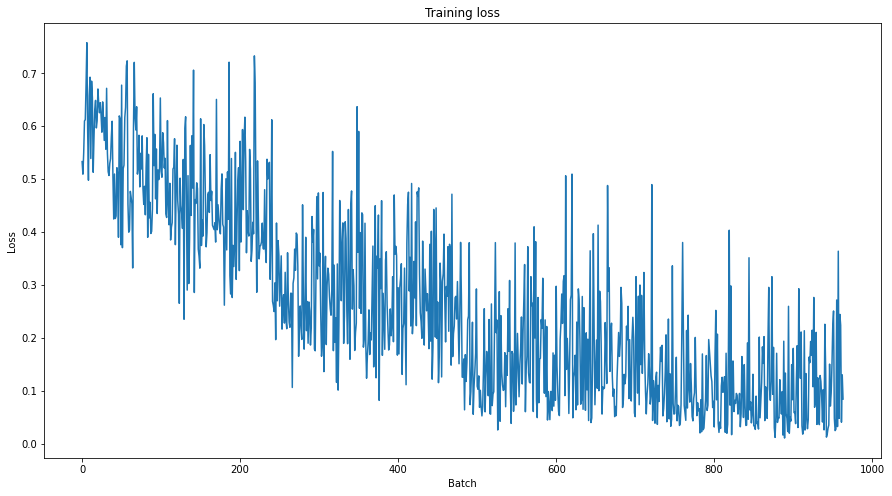

In [54]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Now we have fine tuned our model for idenitifying whether a given sentence is grammatically correct. But now we need to test the model with our test data set. We will use the provided out_domain_dev dataset.

In [62]:
test_data = pd.read_csv("data/out_domain_dev.tsv", delimiter='\t', header=None, 
                            names=['sentence_source', 'label', 'label_notes', 'sentence'])

sentences = test_data.sentence.values

# Here we are adding the CLS and SEP tokens to the sentence beginning and end.
sentences = ['[CLS] ' + s + ' [SEP]' for s in sentences]
labels = test_data.label.values

tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
tokenized_texts[1]

input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

# We are padding here as well since we are going to batch evaluate
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', 
                    truncating='post', padding='post')

masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [63]:
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)


Since we have now aquired the predictions and their related actual labels, can use them to evaluate the model performance.

As the metric, we will use `Matthews Correlation Coefficient`. This was initially designed to measure the quality of binary classifications. But it can be modified to use in a multiclass case as well. Its formula as follows.

<center><image src="imgs/14.png" width="500"/></center>

If retuns outputs in the range of -1 to +1 with +1 being a proper prediction and -1 being a inverse prediction. 0 indicates mere random predictions in general.

We are using this because, General Language Understanding Evaluation (GLUE) benchmark is based on this MCC value.

We will use sklearn package for MCC calculation.

In [74]:
from sklearn.metrics import matthews_corrcoef

matthew_set = []

for i in range(len(true_labels)):

    matthews = matthews_corrcoef(true_labels[i], 
                                np.argmax(predictions[i], 
                                axis=1))
    matthew_set.append(matthews)

In [75]:
matthew_set

[0.049286405809014416,
 -0.21684543705982773,
 0.4732058754737091,
 0.2809003238667948,
 0.4133804997216296,
 0.7410010097502685,
 0.3768673314407159,
 0.0,
 0.8320502943378436,
 0.5659164584181102,
 0.6042179781166439,
 0.647150228929434,
 0.8749672939989046,
 0.647150228929434,
 0.38461538461538464,
 0.4133804997216296,
 0.0]

Mathhew scores for each batch shows a positive values in most cases, which is a good sign. We can aggregate the values and then calculate the matthew score for the whole dataset as well if needed.